# Pipeline for Regression Competition

In [1]:
import os
import urllib
import itertools

In [2]:
# Change this constants for another table
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
DATASET_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"
DATASET_PATH = os.path.join("datasets")
target_name = "median_house_value"

In [3]:
import numpy as np
import numpy.ma as ma

import pandas as pd
from pandas.plotting import scatter_matrix

# Models
import sklearn
from sklearn.model_selection import train_test_split

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

from tqdm.autonotebook import tqdm
from tqdm import tqdm
tqdm.pandas()

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# To make this notebook's output identical at every run
np.random.seed(0)

# Where to save the figures
PROJECT_ROOT_DIR = "."
OUT_IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "analytics_images")
os.makedirs(OUT_IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(OUT_IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

/home/leo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
/home/leo/anaconda3/lib/python3.7/site-packages/tqdm/std.py:725: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
# Fetch dataset files
def fetch_data(dataset_url=DATASET_URL, dataset_path=DATASET_PATH):
    if not os.path.isdir(dataset_path):
        os.makedirs(dataset_path)
    if DATASET_URL.endswith('.tgz'):
        import tarfile
        tgz_path = os.path.join(dataset_path, "dataset.tgz")
        urllib.request.urlretrieve(dataset_url, tgz_path)
        dataset_tgz = tarfile.open(tgz_path)
        dataset_tgz.extractall(path=dataset_path)
        dataset_tgz.close()

fetch_data()

In [5]:
def load_data(dataset_path=DATASET_PATH):
    csv_path = os.path.join(dataset_path, "housing.csv")
    return pd.read_csv(csv_path)

df = load_data()
df.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


At this stage, it is useful to check what type the objects are and how many missing values there are.

In [7]:
df["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [8]:
df.describe()

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

Plotting the distribution of numerical variables.

Saving figure attribute_histogram_plots


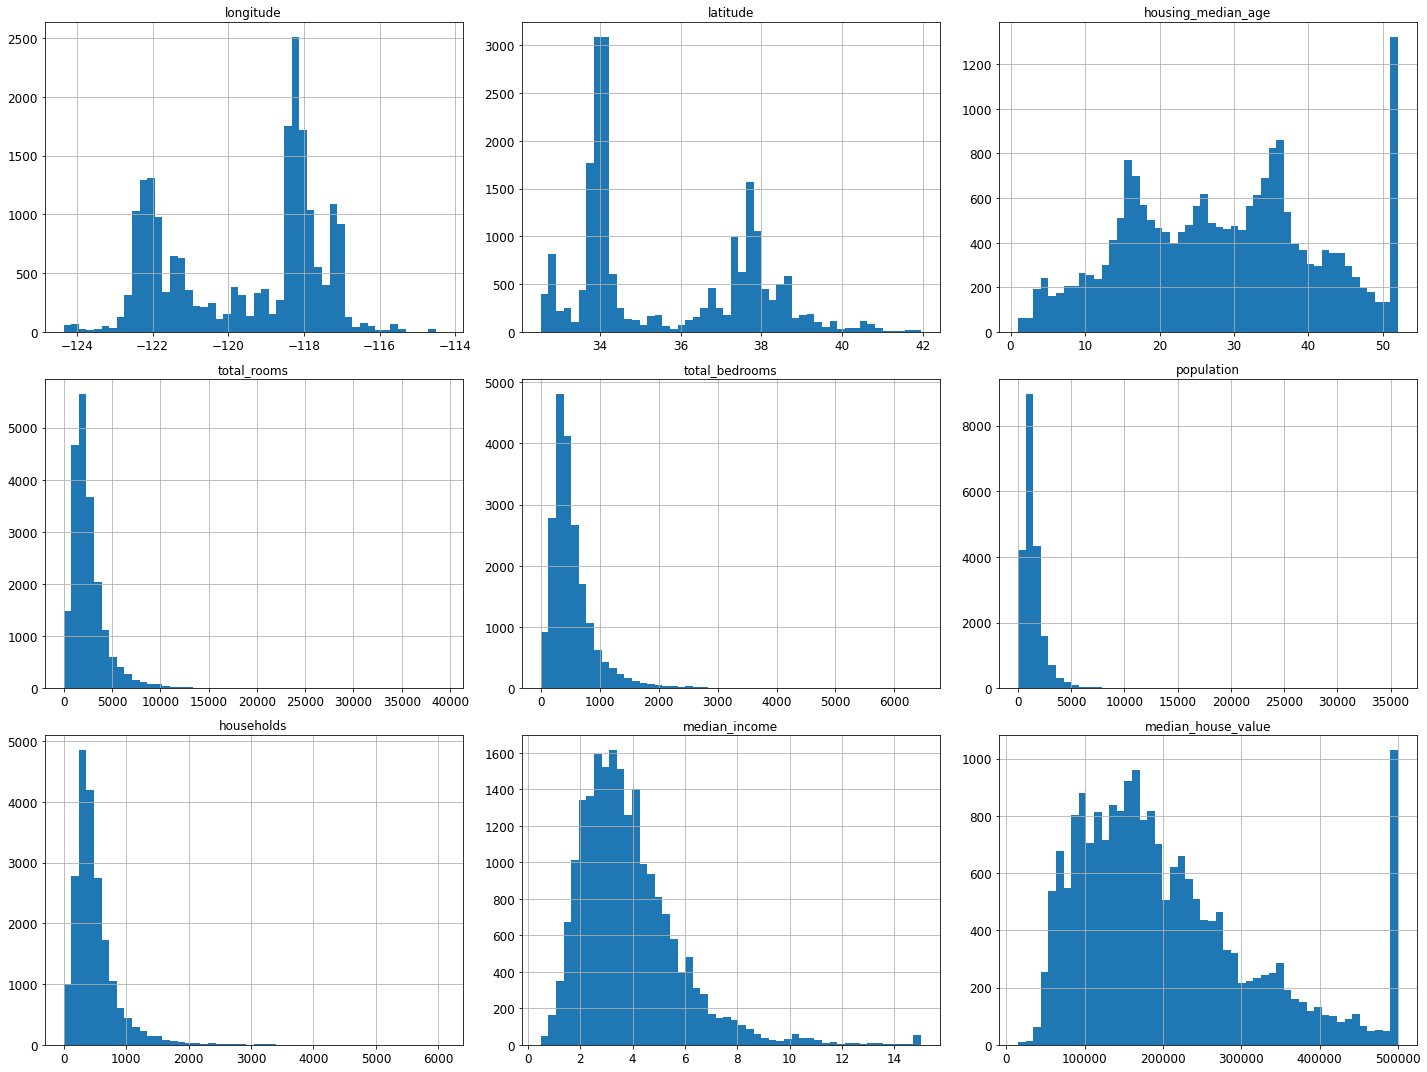

In [9]:
df.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

# Discover and visualize geodata

Saving figure housing_prices_scatterplot


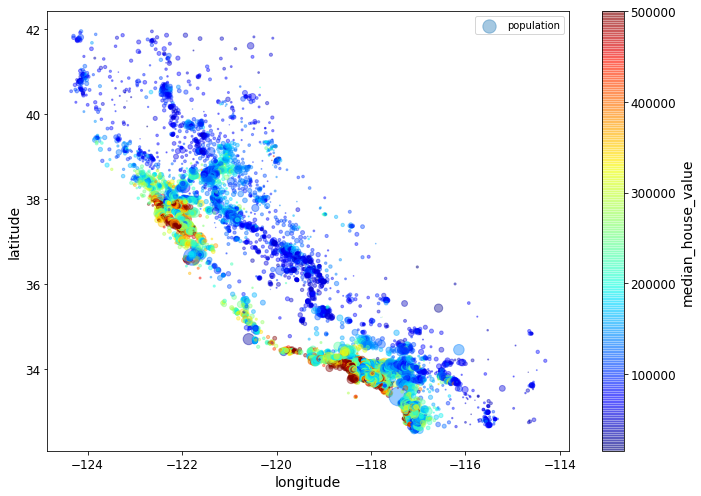

In [11]:
df.plot(kind="scatter",
        x="longitude", y="latitude",
        alpha=0.4,
        s=df["population"]/100,
        label="population",
        figsize=(10,7),
        c="median_house_value",
        cmap=plt.get_cmap("jet"),
        colorbar=True,
        sharex=False);

plt.legend();
save_fig("housing_prices_scatterplot")

# Correlation of variables

Now let's determine how the data correlates with the target variable.

In [12]:
target_name = "median_house_value"
corr_matrix = df.corr()
corr_matrix[target_name].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [14]:
# attributes = abs(corr_matrix[target_name]).sort_values(ascending=False)[0:4].index
# scatter_matrix(df[attributes], figsize=(12, 8))
# save_fig("scatter_matrix_plot")

Saving figure median_house_value_vs_median_income


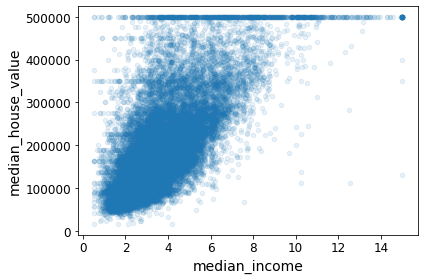

In [15]:
df.plot(kind="scatter",
        x=attributes[1],
        y=attributes[0],
        alpha=0.1)
save_fig(f"{attributes[0]}_vs_{attributes[1]}")

Let's take pairs of features and check if there is a linear correlation between the target variable and the interacting attributes.

In [16]:
numeric_cols = df.select_dtypes(include=np.number).columns
numeric_cols = numeric_cols.drop([target_name])
X = df[numeric_cols]
y = df[target_name]

Let's find correlations.

In [17]:
def make_transformations(X):
    """Make functional transformations for all numeric
    columns of dataset and returns dictionary of
    transformated dataset versions"""
    d = {'x': X,
         'x**0.5': X**0.5,
         'x**2': X**2,
         'log(x)': X.apply(np.log),
         'tanh(x)': X.apply(np.tanh),
         'tanh(ln(x))': X.apply(lambda x: np.tanh(np.log(x))),
         'ln(tanh(x))': X.apply(lambda x: np.log(np.tanh(x))),
         '1/x': 1/X,
         '1/x**0.5': X**(-0.5),
         '1/x**2': X**(-2),
         '1/log(x)': X.apply(lambda x: 1/np.log(x)),
         '1/tanh(x)': X.apply(lambda x: 1/np.tanh(x)),
         '1/tanh(log(x))': X.apply(lambda x: 1/np.tanh(np.log(x))),
         '1/log(tanh(x))': X.apply(lambda x: 1/np.log(np.tanh(x))),
         '1/log(x)**2': X.apply(lambda x: np.power(np.log(x), -2)),
         '1/tanh(x)**2': X.apply(lambda x: np.power(np.tanh(x), -2))}

    for key in d:
        # new column names for every transformation
        start, end = key.split('x')
        d[key].columns = start + d[key].columns + end
    return d

d = make_transformations(X)

/home/leo/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [18]:
%%time

total = pd.concat([d[key] for key in d], axis=1).dropna(axis=1, how='all')
basic_columns = total.columns

composition = []
coefficient = []
df_c = pd.DataFrame({'composition':[],
                     'coefficient':[]})


def find_good_compositions(df_c, num):
    '''Find compositions with good correlation coefficients
    for num of attributes '''
        
    for c in tqdm(set(itertools.combinations(basic_columns, num))):
        x = np.ones(total.shape[0])
        for i in range(num):
            x *= total[c[i]]
        cc = abs(np.corrcoef(x, y)[0, 1])
        if cc > 0.1:
            composition.append(' * '.join(c))
            coefficient.append(cc)
    return pd.concat([df_c, pd.DataFrame({'composition':composition,
                                         'coefficient':coefficient})], axis=0)

if not os.path.exists('df_c.csv'):
    df_c = find_good_compositions(df_c, 2)
    df_c = find_good_compositions(df_c, 3)
    df_c = df_c.sort_values(by='coefficient', ascending=False)
    df_c.to_csv('df_c.csv')
else:
    df_c = pd.read_csv('df_c.csv', index_col=0)

  0%|          | 0/7021 [00:00<?, ?it/s]/home/leo/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2449: RuntimeWarning: invalid value encountered in subtract
  X -= avg[:, None]
/home/leo/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/leo/anaconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/home/leo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
100%|██████████| 273819/273819 [06:28<00:00, 704.78it/s]


CPU times: user 25min 38s, sys: 1min 28s, total: 27min 7s
Wall time: 6min 35s


In [19]:
def find_best_compositions(df_c):
    def make_bool_mask(s):
        return np.array([col in s for col in numeric_cols])

    df_b = pd.DataFrame(np.stack(df_c.composition.apply(make_bool_mask).values),
                        columns=numeric_cols,
                        index =df_c.index)

    df_c = pd.concat([df_c, df_b], axis = 1)
    d = df_c.drop(['composition', 'coefficient'], axis=1)
    best_current_row = d.iloc[0].copy()

    print(df_c.iloc[0].composition, df_c.iloc[0].coefficient)
    best_combinations = [df_c.iloc[0].composition]

    for i in tqdm(d.index):
        if np.any(best_current_row & d.loc[i]):
            continue
        else:
            best_current_row = best_current_row | d.loc[i] 
            print(df_c.loc[i].composition, df_c.loc[i].coefficient)
            best_combinations.append(df_c.loc[i].composition)
            if np.all(best_current_row):
                break
                
    return best_combinations

best_combinations = find_best_compositions(df_c)

  1%|          | 311/42775 [00:00<00:13, 3104.78it/s]

households * median_income * 1/population 0.7456280675159189


 23%|██▎       | 9627/42775 [00:02<00:08, 3763.48it/s]

longitude * 1/log(latitude) * 1/tanh(log(latitude)) 0.49108911795170795


 41%|████      | 17451/42775 [00:04<00:06, 3893.81it/s]

housing_median_age * total_rooms * housing_median_age**0.5 0.27409161157562373


100%|██████████| 42775/42775 [00:11<00:00, 3765.72it/s]


In [27]:
composite_features = dict()
for combination in best_combinations:
    cols = combination.split(' * ')
    x = np.ones(total.shape[0])
    for col in cols:
        x *= total[col]
    composite_features[combination] = x

composite_features = pd.DataFrame(composite_features)

In [ ]:
%load_ext memory_profiler
%memit

# Modeling

With composite features

In [83]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(pd.concat([df.drop([target_name], axis=1), composite_features], axis=1),
                                                    y, test_size = 0.2, random_state=42)
n = 1000

model = CatBoostRegressor(iterations=n,
                          learning_rate=0.1,
                          depth=10,
                          cat_features=['ocean_proximity'])
model.fit(X_train, y_train, verbose_eval=False)

y_pred = model.predict(X_test)
print(mean_absolute_error(y_test, y_pred))

29472.39743794044


План:
- Упростить процедуру представления данных
- Проверка на мультиколинеарность соответствующих признаков между собой

# Source for start ideas
- https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb